# Rojové algoritmy

Na dnešním cvičení se podíváme na další druhy přírodou inspirovaných algoritmů, které se používají pro optimalizační úlohy. Konkrétně to bude algoritmus na optimalizaci pomocí hejna částic a optimalizaci mravenčí kolonií. Oba algoritmy jsou relativně jednoduché na implementaci, a proto je napíšeme sami.

## Optimalizace hejnem částic

Optimalizace hejnem částic je optimalizační algoritmus inspirovaný chováním hejn ryb nebo ptáků při hledání potravy, který se používá pro spojitou optimalizaci. Jedinec, typicky vektor R čísel, se nazývá částice a pohybuje se v hejnu prostorem parametrů. Každá částice je reprezentovaná pomocí 2 vektorů, které určují její pozici a rychlost. Navíc si pamatuje pozici v prostoru, kde měla nejlepší fitness a celé hejno si pamatuje pozici, kde měla nějaká částice nejlepší globální fitness. 

Algoritmus je pak velice jednoduchý -- každá částice se pohybuje v prostoru a je přitahovaná k místu se svým nejlepším řešením a k místu globálního nejlepšího řešení. Na začátku se inicializuje každé částici pozice a rychlost náhodně. Pak se pro každou částici spočítá její fitness, updatuje se dosavadní nejlepší pozice jedince a globální nejlepší pozice v hejnu. Nakonec se spočítá nová rychlost a pozice jedince z původní pozice a rychlosti, jejího nejlepšího místa a globálního nejlepšího místa v hejnu. Toto se opakuje dokud není splněno nějaké ukončovací kritérium, například počet iterací.


Zkusíme se tedy podívat na algoritmus optimalizace hejnem částic (v angličtině particle swarm optimalization (PSO)). Implementace je snadná, protože de facto stačí jenom opsat rovnice.

In [1]:
from collections import namedtuple
import math
import functools
import numpy as np
import csv
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import collections as mc

Začneme tím, že si definujeme třídu pro částici, která je definovaná svou pozicí a rychlostí. Zároveň si pamatuje svou nejlepší pozici v historii. Zároveň definujeme i metodu, aby se jedinec uměl sám vypsat.

In [2]:
class Particle:
    def __init__(self, position, speed):
        self.position = position
        self.speed = speed
        self.best_position = position
            
    def __print__(self):
        return str(self.position) + ', ' + str(self.speed) + ', ' + str(self.best_position)

Na začátku algoritmu budeme potřebovat umět nainicializovat hejno. To uděláme tak, že každé částici zvolíme náhodnou počáteční pozici a rychlost. Rychlosti se typicky nastavují menší. 

In [3]:
def init_swarm(size, dimension):
    swarm = []
    for _ in range(size):
        swarm.append(Particle(position = np.random.uniform(size=(1,dimension)), 
                              speed = 0.2*np.random.uniform(size=(1,dimension)) - 0.1))
    return swarm

Dále budeme potřebovat funkci na aktualizaci pozic a rychlostí všech částic v hejnu podle rovnic.

In [4]:
def update_swarm(swarm, fit, best_global, phi1=1, phi2=0.5, omega=0.95):
    for particle in swarm:
        particle.speed = omega*particle.speed + phi1*(particle.best_position - particle.position) + phi2*(best_global - particle.position)
        particle.position = particle.position + particle.speed
        
        if fit(particle.position) < fit(particle.best_position):
            particle.best_position=particle.position
    return swarm

Také bude potřeba funkce na update nejlepšího globálního řešení. K tomu si definujeme fitness funkci, která bude jen hodnota rastrigin funkce v daném bodě.

In [5]:
def compute_best_global_position(swarm, fit):
    return min(swarm, key=lambda x: fit(x.best_position)).best_position

# fitness funkce
def fitness(position):
    position = position[0]
    N = len(position)
    A = 10
    value = A*N
    for i in range(0,len(position)):
        value += position[i]**2 - A*math.cos(2*math.pi*position[i])
    return value, 

Nyní už máme všechny funkce, takže si už můžeme definovat hlavní kód algoritmu optimalizace hejnem částic.

In [6]:
def pso(fitness, swarm_size, problem_dim, max_iters):
    swarm = init_swarm(size=swarm_size, dimension=problem_dim)
    best_global_position = compute_best_global_position(swarm, fitness)
    best_fitness = []
    for iteration in range(max_iters):
        swarm = update_swarm(swarm, fitness, best_global_position)
        best_global_position = compute_best_global_position(swarm, fitness)
        print(f'{iteration:4}: {fitness(best_global_position)[0]:.4f}')
        best_fitness.append(fitness(best_global_position)[0])
    return best_global_position, best_fitness

Když máme napsaný celý algoritmus, můžeme ho zkusit otestovat například na problému [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function), který jsme řešili na cvičení s evolučními algoritmy. O této funkci jsme si říkali, že je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Navíc nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. Minimum funkce je v bodě 0 s hodnotou 0.

   0: 2.3579
   1: 1.6636
   2: 1.2311
   3: 1.1749
   4: 1.1749
   5: 1.1749
   6: 1.1749
   7: 1.1749
   8: 1.0494
   9: 1.0494
  10: 1.0006
  11: 1.0006
  12: 1.0006
  13: 1.0006
  14: 1.0006
  15: 0.9967
  16: 0.9954
  17: 0.9954
  18: 0.9954
  19: 0.9954
  20: 0.9954
  21: 0.9954
  22: 0.9954
  23: 0.9953
  24: 0.9952
  25: 0.9951
  26: 0.9951
  27: 0.9950
  28: 0.9950
  29: 0.9950
best position
[[ 9.66919888e-05  9.94766510e-01 -2.24821532e-04  6.70260740e-05]]


Text(0.5, 0, 'Generace')

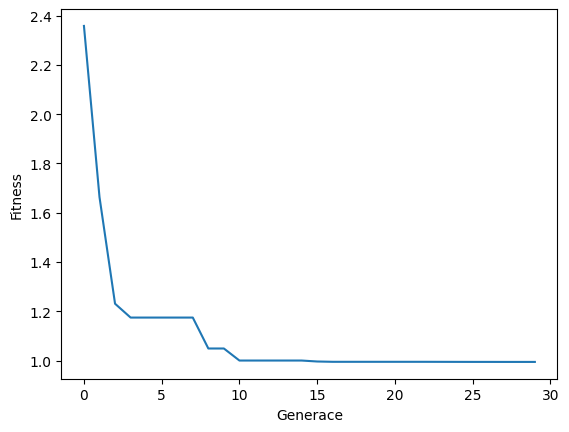

In [7]:
best_position, best_fitness = pso(fitness, swarm_size=1000, problem_dim=4, max_iters=30)
print('best position')
print(best_position)

plt.plot(best_fitness)
plt.ylabel('Fitness')
plt.xlabel('Generace')

Zde si můžeme zkusit měnit dimenzi problému a pozorovat, že pro rostoucí dimenzi je třeba zvětšovat velikost hejna, aby se algoritmus nezasekl v lokálním optimu a že na počtu generací to až zas tolik nezáleží, protože algoritmus brzy zkonverguje do nějakého optima a tam už zůstane.

## Optimalizace mravenčí kolonií

Optimalizace mravenčí kolonií (Ant Colony Optimization (ACO)) je algoritmus inspirovaný chováním mravenců při hledání potravy, který se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na problém hledání cest v grafu. 

Mravenci se pohybují v prostředí a zanechávají za sebou feromonouvou stopu, která časem slábne a díky které spolu komunikují a slouží jim jako pozitivní druh zpětné vazby. Mravenec začne v náhodném bodě a rozhoduje se kam půjde dál. Nejprve se pohybují náhodně kolem mraveniště. Jakmile naleznou potravu, vrací se stejnou cestou, kterou k potravě došli a zanechávají za sebou feromonovou stopu. Jakmile nějkaý další mravenec narazí na feromonovou stopu, s větší pravděpodobností se po ní vydá spíše, než aby dále prozkoumával prostředí. Čím více mravenců se pohybuje mezi zdrojem potravy a mraveništěm, tím silnější je stopa a šance, že cesta přitáhne další mravence. Navíc na kratší cestě feromon vyprchává pomaleji, takže bude silnější a bude přitahovat více mravenců.

Jen tak pro zajímavost rozhraní pro modelování různých přírodou inspirovaných systémů a algoritmů [NetLogo](http://ccl.northwestern.edu/netlogo/) poskytuje i simulaci mravenečků při hledání potravy. Podívat se na ně můžeme [zde](http://www.netlogoweb.org/launch#http://www.netlogoweb.org/assets/modelslib/Sample%20Models/Biology/Ants.nlogo).

Zkusíme si s jeho pomocí vyřešit [Problém obchodního cestujícího](https://en.wikipedia.org/wiki/Travelling_salesman_problem), který se dá převést na problém hledání nejkratší Hamiltonovské kružnice v úplném grafu. Hamiltonovská kružnice v grafu je kružnice, která prochází všemi vrcholy. Implementace už je zde trochu složitější, ale pořád celkem rozumná.

Nejprve si vytvoříme kolekci ```namedtuple```, do které si uložíme informace o vrcholu, tedy jeho souřadnice a název. Je vhodnější než normální třída, protože je to rychlejší struktura. 

In [12]:
Vertex = namedtuple('Vertex', ['name', 'x', 'y', 'demand'])

Dále budeme potřebovat funkci, co nám spočítá vzdálenost dvou bodů. To uděláme chytře a použijeme k tomu lru (least recently used) cache, která si pamatuje si vyhodnocené funkce a při jejich opakovaném volání se stejnými parametry se nemusí znovu vyhodnocovat.

In [3]:
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return ((v1.x - v2.x)**2+(v1.y - v2.y)**2)**(1/2)

Dále se bude hodit fitness funkce, která jen vyhodnotí danou cestu mezi městy tak, ze bere dvojice po sobě jdoucích vrcholů v řešení a sčítá vzdálenosti měst.

In [4]:
def fitness(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:]):
        solution_distance += distance(vertices[x], vertices[y])
    solution_distance += distance(vertices[solution[-1]], vertices[solution[0]])
    return solution_distance

Samotný algoritmus bude ještě potřebovat funkci na počáteční inicializaci feromonu, která by sice měla být stopa všude nulová, ale protože s ní pracujeme jako s pravděpodobností, tak by to nefungovalo, tak ji nastavíme na nějakou malou hodnotu. Také bude potřeba dělat update feromonu a to tak, že na všechny hrany v cestě rozpočítáme rovnoměrně tu fitness, která říká, jak byla váha dobrá. A protože délku chceme minimalizovat, takže použijeme inverzní Q/fit, kde Q bude nějaká konstanta.

In [5]:
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

def update_pheromone(pheromones_array, solutions, fits, Q=100, rho=0.6):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fit in zip(solutions, fits):
        for x, y in zip(solution, solution[1:]):
            pheromone_update[x][y] += Q/fit
        pheromone_update[solution[-1]][solution[0]] += Q/fit
    
    return (1-rho)*pheromones_array + pheromone_update

Ještě nám zbývá pomocná funkce, kde mravenec generuje řešení, tedy náhodně prochází města, dokud neobejde všechny. Pak už můžeme napsat hlavní funkci algoritmu, kde se vytváří řešení, a podle jejich kvality se upravuje feromon na hranách. Zároveň si pamatujeme nejlepší řešení, abychom ho na konci mohli vrátit.

In [6]:
def generate_solutions(vertices, pheromones, distance, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu dalsiho mesta
    def compute_prob(v1, v2):
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 1e-6 else 1e-6

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(pheromones_shape))
        solution = [np.random.randint(0, pheromones_shape)]
        available.remove(solution[0])
        while available:
            # probs = np.array(list(map(lambda x: compute_prob(solution[-1], x), available)))
            probs = np.array([compute_prob(solution[-1], x) for x in available])
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            solution.append(selected)
            available.remove(selected)
        yield solution


In [69]:
import xml.etree.ElementTree as ET
def parse_xml(path: str):
    tree = ET.parse(path)
    root = tree.getroot()
    nodes = root.find("network").find("nodes")
    vertices = []
    for vertex in nodes:
        type = vertex.attrib['type']
        x = float(vertex.find('cx').text)
        y = float(vertex.find('cy').text)
        if type == '0':
            V = Vertex(name=vertex.attrib['id'], x=x,y=y,demand=(float("inf")))
            vertices = [V] + vertices
        else:
            V = Vertex(name=vertex.attrib['id'], x=x,y=y,demand=0.0)
            vertices.append(V)

    capacity = float(root.find("fleet").find("vehicle_profile").find("capacity").text)
    for req in root.find("requests"):
        quantity = float(req.find("quantity").text)
        ix_to_be_removed = list(map(lambda x: x.name == req.attrib['node'], vertices)).index(True)
        vertices[ix_to_be_removed] = Vertex(name=vertices[ix_to_be_removed].name, 
                                                          x=vertices[ix_to_be_removed].x,
                                                          y=vertices[ix_to_be_removed].y,
                                                          demand=quantity)
        # pprint.pprint(vertices[ix_to_be_removed])
    return vertices, capacity

In [71]:
path = "domaci_ukol_data/data_422.xml"
vertices, capa = parse_xml(path)
print(capa)
pprint.pprint(vertices)

200.0
[Vertex(name='421', x=0.0, y=0.0, demand=inf),
 Vertex(name='1', x=5.7735, y=0.0, demand=40.0),
 Vertex(name='2', x=2.8867, y=5.0, demand=40.0),
 Vertex(name='3', x=-2.8868, y=5.0, demand=40.0),
 Vertex(name='4', x=-5.7735, y=0.0, demand=40.0),
 Vertex(name='5', x=-2.8867, y=-5.0, demand=40.0),
 Vertex(name='6', x=2.8868, y=-5.0, demand=40.0),
 Vertex(name='7', x=8.6603, y=5.0, demand=40.0),
 Vertex(name='8', x=0.0, y=10.0, demand=40.0),
 Vertex(name='9', x=-8.6603, y=5.0, demand=40.0),
 Vertex(name='10', x=-8.6603, y=-5.0, demand=40.0),
 Vertex(name='11', x=0.0, y=-10.0, demand=40.0),
 Vertex(name='12', x=8.6603, y=-5.0, demand=40.0),
 Vertex(name='13', x=5.3405, y=0.75, demand=10.0),
 Vertex(name='14', x=3.3198, y=4.25, demand=10.0),
 Vertex(name='15', x=6.4952, y=-1.25, demand=10.0),
 Vertex(name='16', x=7.2169, y=-2.5, demand=20.0),
 Vertex(name='17', x=7.9386, y=-3.75, demand=10.0),
 Vertex(name='18', x=6.4952, y=1.25, demand=10.0),
 Vertex(name='19', x=7.2169, y=2.5, demand

In [99]:
def generate_solutions_VRP(vertices: list[Vertex.demand], pheromones, distance, N, capacity, alpha=1, beta=3):
    def compute_prob(v1, v2, capacity):
        if vertices[v2].demand > capacity or v1 == v2 or vertices[v2].demand == 0:
            return 1e-12
        dist = 1/distance(vertices[v1], vertices[v2])
        tau = pheromones[v1, v2]
        ret = pow(tau, alpha) * pow(dist,beta)
        return ret if ret > 1e-6 else 1e-6

    pheromones_shape = pheromones.shape[0]
    for i in range(N):
        available = list(range(1,pheromones_shape))
        solution = [0]
        cap = capacity
        while available:
            probs = np.array([compute_prob(solution[-1], x, cap) for x in [0]+available])
            selected = np.random.choice([0]+available, p=probs/sum(probs))
            cap -= vertices[selected].demand
            if vertices[selected].demand == float("inf"):
                solution.append(0)
                cap = capacity
                continue
            solution.append(selected)
            available.remove(selected)
        yield solution

Nyní už si můžeme vytvořit hlavní kód ACO.

In [100]:
def ant_solver(vertices, distance, capacity, ants=10, max_iterations=3000, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float('inf')
    
    for i in range(max_iterations):
        solutions = list(generate_solutions_VRP(vertices, pheromones, distance, ants, capacity,
                                                 alpha=alpha, beta=beta))
        fits = [fitness(vertices, distance, s) for s in solutions]
        pheromones = update_pheromone(pheromones, solutions, fits, Q=Q, rho=rho)
        
        for s, f in zip(solutions, fits):
            if f < best_fitness:
                best_fitness = f
                best_solution = s
        
        print(f'{i:4}, {np.min(fits):.4f}, {np.mean(fits):.4f}, {np.max(fits):.4f}')
    return best_solution, pheromones

Zkusíme si nyní algoritmus otestovat na hlavních evropských městech, vstupní data jsou uložena v souboru *cities.csv*.

In [107]:
path = "domaci_ukol_data/data_32.xml"
vertices, capacity = parse_xml(path)
best_sol, pheromones = ant_solver(vertices, distance, capacity)

   0, 1574.0396, 1731.3470, 1857.8790
   1, 1483.1516, 1711.8309, 2012.6789
   2, 1208.4415, 1560.8380, 1814.4873
   3, 1351.7766, 1676.3980, 1882.9400
   4, 1473.2651, 1611.1992, 1914.2675
   5, 1330.6226, 1633.2761, 1954.4267
   6, 1426.8436, 1664.3322, 1829.6163
   7, 1326.9616, 1613.0714, 1811.0300
   8, 1339.6785, 1600.5807, 1752.4530
   9, 1173.0419, 1480.8136, 1834.0579
  10, 1221.9682, 1534.3710, 1685.8083
  11, 1377.3130, 1617.6540, 1987.1662
  12, 1426.2613, 1620.9412, 1762.8876
  13, 1382.8738, 1574.2354, 1823.5857
  14, 1345.4254, 1592.7408, 1950.0005
  15, 1433.0629, 1620.6431, 1793.0193
  16, 1351.0494, 1637.4849, 1797.3553
  17, 1337.7755, 1598.1645, 1832.5737
  18, 1340.3765, 1647.5516, 1846.5979
  19, 1382.4033, 1612.8261, 1850.4213
  20, 1343.8826, 1625.2273, 1846.2910
  21, 1385.3861, 1573.6849, 1884.8682
  22, 1363.5238, 1597.0181, 1788.8039
  23, 1358.6774, 1624.7127, 1866.9300
  24, 1335.6792, 1580.8694, 1773.2408
  25, 1405.8888, 1548.8500, 1742.7152
  26, 1249.8

In [108]:
# vertices = []

# with open('cities.csv') as cities_file:
#     csv_reader = csv.reader(cities_file, delimiter=',')
#     for row in csv_reader:
#         vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

# pprint.pprint(vertices)

# best_solution, pheromones = ant_solver(vertices, distance)

Vykreslíme si nalezené řešení a množství feromononu na jednotlivých hranách. Feromon bude modrý, tloušťka čáry značí množství feromonu na hraně. Červenou barvou vykreslíme nejlepší řešení a vypíšeme si i jeho fitness a pořadí měst v něm. Odkomentováním zakomentované řádky si můžete vyzkoušet, jak různé nastavení alpha a beta ovlivňuje nalezená řešení. 

Fitness:  1069.6251009108291
[Vertex(name='1', x=82.0, y=76.0, demand=inf),
 Vertex(name='31', x=85.0, y=60.0, demand=14.0),
 Vertex(name='27', x=80.0, y=55.0, demand=2.0),
 Vertex(name='17', x=88.0, y=51.0, demand=18.0),
 Vertex(name='13', x=98.0, y=52.0, demand=21.0),
 Vertex(name='2', x=96.0, y=44.0, demand=19.0),
 Vertex(name='8', x=84.0, y=39.0, demand=16.0),
 Vertex(name='15', x=61.0, y=59.0, demand=3.0),
 Vertex(name='30', x=20.0, y=70.0, demand=2.0),
 Vertex(name='19', x=19.0, y=32.0, demand=1.0),
 Vertex(name='23', x=5.0, y=42.0, demand=4.0),
 Vertex(name='7', x=58.0, y=30.0, demand=12.0),
 Vertex(name='1', x=82.0, y=76.0, demand=inf),
 Vertex(name='18', x=91.0, y=2.0, demand=19.0),
 Vertex(name='20', x=93.0, y=3.0, demand=24.0),
 Vertex(name='32', x=98.0, y=5.0, demand=9.0),
 Vertex(name='22', x=98.0, y=14.0, demand=12.0),
 Vertex(name='4', x=49.0, y=8.0, demand=6.0),
 Vertex(name='3', x=50.0, y=5.0, demand=21.0),
 Vertex(name='24', x=42.0, y=9.0, demand=8.0),
 Vertex(name='5

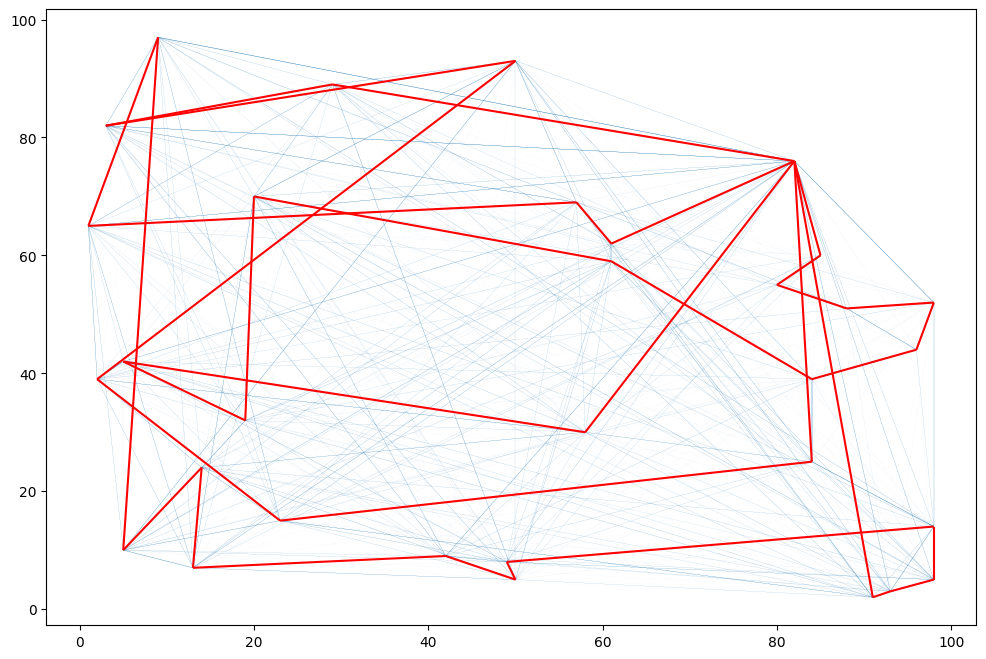

In [110]:
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(pheromones[i][j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_sol

# tady muzeme zkouset vliv jednotlivych parametru na vygenerovane reseni
# solution = list(generate_solutions(vertices, pheromones, distance, N=1, alpha=3, beta=1))[0]

print('Fitness: ', fitness(vertices, distance, solution))

solution_vertices = [vertices[i] for i in solution]
pprint.pprint(solution_vertices)

solution_lines = []
for i, j in zip(solution, solution[1:]):
    solution_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])
solution_lines.append([(vertices[solution[-1]].x, vertices[solution[-1]].y), (vertices[solution[0]].x, vertices[solution[0]].y)])
solutions_lc = mc.LineCollection(solution_lines, colors='red')
ax.add_collection(solutions_lc)

Pěkná simulace hledání nejkratší cesty v grafu se nachází [zde](http://thiagodnf.github.io/aco-simulator).

## Úkol na cvičení

Poslední zmiňovaný algoritmus, který zde ale není naimplementovaný, je optimalizace pomocí včelí kolonie. Umělé včelí kolonie (ABC) je optimalizační algoritmus založený na chování včel při hledání potravy. Včely jsou rozděleny do třech skupin - na dělnice, vyčkávající včely a průzkumníky. Každá dělnice opracovává jeden zdroj jídla (a pozice těchto zdrojů kódují řešení). Při opracování dělnice navštíví zdroje jídla v okolí, a pokud je jiné řešení kvalitnější (má lepší fitness) nahradí svůj zdroj tímto novým zdrojem. Potom se všechny dělnice sejdou v úle, vymění si informace o kvalitě zdrojů a vyčkávající včely si vyberou některé z těchto zdrojů pomocí ruletové selekce. Dělnice si zároveň pamatují, jak dlouho už opracovávají daný zdroj, a pokud přesáhne tato doba nastavený limit, zdroj opustí a stanou se z nich průzkumníci. Průzkumníci prohledávají prostor náhodně a hledají nové zdroje potravy

Zkuste si tedy naimplementovat ve zbytku cvičení optimalizaci pomocí včelí kolonie a vyřešit s ní třeba problém rastrigin funkce, který je výše vyřešený pomocí optimalizace hejna částic.

## Domácí úkol

Za domácí úkol budete mít vyřešit pomocí optimalizace mravenčí kolonií [Vehicle Routing Problem](https://en.wikipedia.org/wiki/Vehicle_routing_problem), což je vlastně jen zobecněný problém obchodního cestujícího na princip optimalizace rozvozu zásilek doručovací společnosti. Jedná se o to, že máme depa, každé má svá vlastní vozidla s danou kapacitou a nějakou množinu zásilek, které je potřeba rozvézt k jejich majitelům. Cílem je najít množinu doručovacích tras tak, aby byly všechny zásilky dodány majitelům a aby byly minimalizované celkové náklady, tedy aby byl použit co nejmenší počet vozidel a aby byly trasy co nejkratší.

V našem případě použijeme zjednodušenou verzi tohoto problému s jedním depem, které má neomezený počet vozidel jednoho typu. Vstupní data najdete ve složce *domaci_ukol_data*, jsou ve formátu xml a obsahují 3 soubory -- 2 malé a jeden větší, které zároveň obsahují:
- Seznam uzlů se souřadnicemi x a y, kdy uzel s typem 0 je depo, a ty ostatní s typem 1 jsou lokace zákazníků.
- Seznam vozidel, v tomto případě máme jeden typ vozidla, které musí začínat a končit v depu a má nějakou maximální kapacitu předmětů, které uveze.
- Seznam požadavků, neboli do jakého uzlu se toho má co dovézt.

Svůj kód, popis řešení, výsledky a jejich rozbor mi pošlete emailem do stanoveného deadline. Pro sepsání popisu algoritmu a výsledků použijte [tento template](https://github.com/kackamac/Prirodou-inspirovane-algoritmy/blob/master/11_rojove%20algoritmy/DU3_spojita_optimalizace.pdf).